In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

df = pd.read_csv('~/Desktop/BINF305/assignment_week_35/network_tf_gene.txt', sep='\t', header=None, skiprows=34, usecols=[0,1,2,3,4])


# filtering TFs on strong confidence experiments and their unambiguous effect on target gene transcription
strong_relations = df[df[4] == 'Strong']
filtered_relations = strong_relations[(strong_relations[2] == '+') | (strong_relations[2] == '-')]

# map TFs and targets to upper for later comparison
filtered_relations[[0,1]] = filtered_relations[[0,1]].applymap(lambda x: x.upper())


# lists of transcription targets, their targets, targets that are TFs themselves and all genes 
tfs = list(map(lambda x: x.upper(), filtered_relations[0].unique()))
targets = list(map(lambda x: x.upper(), filtered_relations[1].unique()))
tf_targets = list(filter(lambda x: x in targets, tfs))
all_genes = list(set(tfs + targets))
all_genes.sort()


# autoregulated genes
autoreg = filtered_relations[filtered_relations[0] == filtered_relations[1]][0].unique()

# Stats
print("Number of")
print("{:<30s} {:>10d}".format("Unfiltered relations: ", len(df)))
print("{:<30s} {:>10d}".format("Genes: ", len(all_genes)))
print("{:<30s} {:>10d}".format("TFs:", len(tfs)))
print("{:<30s} {:>10d}".format("TF targets: ", len(targets)))
print("{:<30s} {:>10d}".format("Autoregulated genes: ", len(autoreg)))
print("{:<30s} {:>10d}".format("Relations after filtering: ", len(filtered_relations)))


# Making adjacency matrix
adj_matrix = sps.lil_matrix((len(all_genes), len(all_genes)), dtype=np.int8)



# Filling matrix
for i in range(len(filtered_relations)):
    tf = filtered_relations[0].iloc[i]
    tf_index = all_genes.index(tf)
    
    target = filtered_relations[1].iloc[i]
    target_index = all_genes.index(target)
    
    
    sign = filtered_relations[2].iloc[i]
    if sign == '+' :
        adj_matrix[tf_index, target_index] = 1
    else: 
        adj_matrix[tf_index, target_index] = -1


        
# Variables for sampling
temp_relations = filtered_relations.copy()
sampled_autoreg = []

# Sampling
for i in range(1000):
    temp_relations[1] = np.random.permutation(np.array(temp_relations[1]))
    temp_autoreg = temp_relations[temp_relations[0] == temp_relations[1]][0].unique()
    sampled_autoreg.append(len(temp_autoreg))

    
sample_mean = np.mean(sampled_autoreg)
print("\nSample mean of autoregulated gene count: ", sample_mean)
sample_variance = np.var(sampled_autoreg)
print("Sample variance of autoregulated gene count: ",sample_variance)

z = (61 - sample_mean) / math.sqrt(sample_variance)
print("Z-value: ", z)
print("P-value: ", 1 - norm.cdf(z))


/home/tor/.local/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Number of
Unfiltered relations:                4610
Genes:                               1094
TFs:                                  144
TF targets:                          1034
Autoregulated genes:                   61
Relations after filtering:           1743

Sample mean of autoregulated gene count:  1.286
Sample variance of autoregulated gene count:  1.256204
Z-value:  53.2777748028545
P-value:  0.0


Beta = 20.0 when K = 2.5 and n = 7


[]

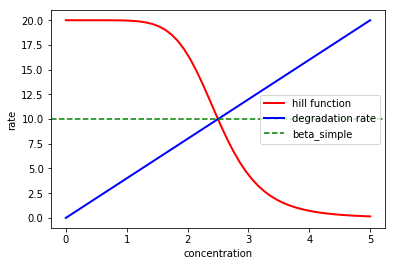

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# configurations
alfa = 4.
beta = 10
beta_simple = 10
K = 2.5
n = 7
x = list(np.linspace(0,5))


def get_config():
    return [alfa, beta, beta_simple,K, n]

def custom_hill(y):
    config = get_config()
    beta = config[1]
    K = config[3]
    n = config[4]
    return beta / (1 + (y/K)**n)

def steady_state_beta(beta):
    config = get_config()
    y_steady = config[2] / config[0]
    beta_simple = config[2]
    K = config[3]
    n = config[4]
    return beta / (1 + (y_steady / K) ** n) - beta_simple


beta = fsolve(steady_state_beta, x0=K)
print("Beta = {} when K = {} and n = {}".format(beta[0], K, n))
y = list(map(custom_hill, x))

x_alfa = list(np.linspace(0,5))
y_alfa = list(map(lambda x: x * alfa, x_alfa))

plt.plot(x, y, 'r-', linewidth=2, label="hill function")
plt.plot(x_alfa, y_alfa, 'b-', linewidth=2, label="degradation rate")
plt.axhline(y = beta_simple, color='g', linestyle='--', label='beta_simple')
plt.xlabel('concentration')
plt.ylabel('rate')
plt.legend()
plt.plot()



[]

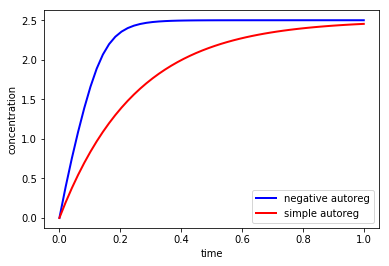

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def hill_function(y, beta, K, n):
    return beta / (1 + (y/K)**n)

def neg_autoreg(y, t, alfa, beta, K, n):
    dydt = hill_function(y, beta, K, n) - alfa * y
    return dydt

def simple(y, t, alfa, beta):
    dydt = beta - alfa * y
    return dydt

# configurations
y0 = 0
t = np.linspace(0,1)
alfa = 4.
beta_simple = 10.
beta = 20
K = 2.5
n = 7

y = odeint(neg_autoreg, y0, t, (alfa,beta, K, n))
y_simple = odeint(simple, y0, t, (alfa, beta_simple))

plt.plot(t, y, 'b-', linewidth=2, label="negative autoreg")
plt.plot(t, y_simple, 'r-', linewidth=2, label="simple autoreg")
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.plot()